# **ViTs para Agave – De Software a Hardware**


### Integrantes del equipo N° #31:
- Arian Yolanda Reyes Aguilar - A01795124
- Oscar Nava Jiménez - A01745524
- Bruno Sánchez García - A01378960

### Asesor del Proyecto: Diego Concepción Villatoro Gerónimo

### Director del Proyecto: Luis Eduardo Falcón Morales
### Proyecto Integrador | Fecha de Entrega: 12/10/2025

### **Propósito de Proyecto**
El proyecto tiene como objetivo implementar y validar un modelo de visión
computacional basado en Vision Transformers (ViTs) para detectar
automáticamente plantas de agave y evaluar su estado de salud mediante
imágenes capturadas en campo. El modelo, desarrollado en PyTorch bajo la
arquitectura bit-STED, ya ha sido probado exitosamente en software. Ahora se
busca llevarlo a una plataforma embebida, específicamente una Raspberry Pi 5,
para evaluar su rendimiento, eficiencia y viabilidad en condiciones reales con
recursos limitados. Esta prueba en hardware permitirá determinar si la solución
es apta para su implementación directa en el entorno agrícola.

### **Contexto sobre Imagenes**

El dataset consta de aproximadamente 2440 imágenes multiespectrales de tamaño 224x224 píxeles, capturadas en cinco campos agrícolas diferentes. Cada imagen está compuesta por múltiples bandas espectrales que incluyen azul (450 nm), verde (560 nm), rojo (650 nm), borde rojo (730 nm) y el infrarrojo cercano (840 nm). Estas imágenes fueron tomadas con drones equipados con sensores especializados, y están destinadas a permitir el análisis detallado de plantas de agave mediante técnicas de visión por computadora. El formato de las imágenes es TIFF multibanda, lo que permite conservar la información espectral necesaria para detectar y evaluar el estado de salud de las plantas.

### **Objetivo de Actividad**

Establecer un modelo de referencia (baseline) para evaluar la viabilidad del problema de detección y clasificación del estado de salud de plantas de agave a partir de imágenes. Este modelo simple servirá como punto de comparación frente al modelo principal basado en Vision Transformers (bit-STED), permitiendo validar si los datos contienen suficiente información para resolver el problema con métodos básicos.

In [18]:
# Librerías estándar y de terceros
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from glob import glob
from tifffile import imread  # Para leer imágenes TIFF multicanal
import pathlib
# Módulos propios del proyecto
from model.transformer import TransformerObjectDetection
from utils.counting import inference

In [2]:

# Definición de rutas de imágenes y etiquetas
IMAGES_DIR = "Zones_cbbox_dataset_10/train/images"
LABELS_DIR = "Zones_cbbox_dataset_10/train/labels"

# Buscar todos los archivos .tif y .txt
imagenes = sorted(glob(os.path.join(IMAGES_DIR, "*.tif")))
etiquetas = sorted(glob(os.path.join(LABELS_DIR, "*.txt")))

# Mostrar cantidades cargadas
print(f"Total de imágenes: {len(imagenes)}")
print(f"Total de etiquetas: {len(etiquetas)}")

Total de imágenes: 2440
Total de etiquetas: 2440


In [3]:
def leer_etiquetas(path_txt, img_width=224, img_height=224):
    """
    Lee un archivo de etiquetas en formato YOLO y convierte las coordenadas
    normalizadas al formato [x1, y1, x2, y2] en píxeles.

    Parámetros:
    - path_txt (str): Ruta del archivo .txt con etiquetas.
    - img_width (int): Ancho de la imagen en píxeles.
    - img_height (int): Alto de la imagen en píxeles.

    Retorna:
    - boxes (list): Lista de cajas delimitadoras [x1, y1, x2, y2].
    """
    boxes = []
    with open(path_txt, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                _, x_c, y_c, w, h = map(float, parts)
                x1 = (x_c - w / 2) * img_width
                y1 = (y_c - h / 2) * img_height
                x2 = (x_c + w / 2) * img_width
                y2 = (y_c + h / 2) * img_height
                boxes.append([x1, y1, x2, y2])
    return boxes

In [4]:
def boxes_xywh_to_xyxy(boxes):
    """
    Convierte una lista de cajas en formato [xc, yc, r] a [x1, y1, x2, y2],
    donde r representa un "radio" de tamaño alrededor del centro.

    Parámetros:
    - boxes (list): Lista de cajas en formato [xc, yc, r].

    Retorna:
    - new_boxes (list): Lista de cajas en formato [x1, y1, x2, y2].
    """
    new_boxes = []
    for (xc, yc, r) in boxes:
        x1 = xc - r
        y1 = yc - r
        x2 = xc + r
        y2 = yc + r
        new_boxes.append([x1, y1, x2, y2])
    return new_boxes

In [5]:
def iou(boxA, boxB):
    """
    Calcula el IoU (Intersection over Union) entre dos cajas delimitadoras.

    Parámetros:
    - boxA (list): Caja [x1, y1, x2, y2].
    - boxB (list): Caja [x1, y1, x2, y2].

    Retorna:
    - float: Valor del IoU.
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter_area = max(0, xB - xA) * max(0, yB - yA)
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    return inter_area / float(boxA_area + boxB_area - inter_area + 1e-6)

In [6]:
def evaluar_detecciones(pred_boxes, gt_boxes, iou_thresh=0.5):
    """
    Compara las cajas predichas con las cajas reales (ground truth)
    usando el umbral de IoU para contar verdaderos positivos, falsos positivos y negativos.

    Parámetros:
    - pred_boxes (list): Cajas predichas en formato [x1, y1, x2, y2].
    - gt_boxes (list): Cajas reales (ground truth) en mismo formato.
    - iou_thresh (float): Umbral mínimo de IoU para considerar un match válido.

    Retorna:
    - tp (int): Verdaderos positivos.
    - fp (int): Falsos positivos.
    - fn (int): Falsos negativos.
    """
    tp = 0
    matched_gt = set()

    for pred_box in pred_boxes:
        for i, gt_box in enumerate(gt_boxes):
            if i in matched_gt:
                continue
            if iou(pred_box, gt_box) >= iou_thresh:
                tp += 1
                matched_gt.add(i)
                break

    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp

    return tp, fp, fn

In [ ]:
def visualizar_agave_detectado(image_np, pred_boxes, scores=None, gt_boxes=None):
    """
    Visualiza una imagen con las detecciones de agave (predicciones y ground truth).

    Corrige automáticamente el tipo y formato de la imagen, y convierte tensores a float.
    """
    # Ajustar dimensiones si tiene batch (1, H, W, 3)
    if image_np.ndim == 4:
        image_np = image_np[0]

    # Convertir a uint8 si es float
    if image_np.dtype != np.uint8:
        image_np = np.clip(image_np, 0, 1) * 255
        image_np = image_np.astype(np.uint8)

    # Crear imagen PIL
    img = Image.fromarray(image_np)
    draw = ImageDraw.Draw(img)

    # Dibujar ground truth (rojo)
    if gt_boxes is not None:
        for box in gt_boxes:
            draw.rectangle(box, outline='red', width=2)

    # Dibujar predicciones (verde)
    if pred_boxes is not None and len(pred_boxes) > 0:
        for i, box in enumerate(pred_boxes):
            draw.rectangle(box, outline='green', width=2)
            if scores is not None and i < len(scores):
                score_val = scores[i]
                if torch.is_tensor(score_val):
                    # Si es tensor de más de un elemento, tomar el primero
                    if score_val.numel() > 1:
                        score_val = score_val.flatten()[0].item()
                    else:
                        score_val = score_val.item()
                score_text = f"{float(score_val):.2f}"
                font = ImageFont.load_default()
                draw.text((box[0], box[1] - 10), score_text, fill='green', font=font)

    # Mostrar resultado
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Detección de plantas de agave")
    plt.show()

In [13]:
# Selección de dispositivo (CPU)
device = torch.device('cuda')

# Ruta al modelo entrenado
model_dir = os.path.join('best.pt')

# Configuración del modelo
n_model = 512
num_blks = 2

# Instanciar modelo con arquitectura personalizada
model = TransformerObjectDetection(
    image_size=224,
    N_channels=3,
    n_model=n_model,
    num_blks=num_blks,
    obj='cbbox',
    device=device,
    bitNet=True
).to(device)

# Cargar pesos entrenados
checkpoint = torch.load(model_dir, map_location=device)
if isinstance(checkpoint, dict):
    model.load_state_dict(checkpoint['model'])
else:
    model.load_state_dict(checkpoint)

model.eval()
print("Modelo cargado exitosamente.")

Modelo cargado exitosamente.


In [14]:
# Seleccionar índice de la imagen a procesar
idx = 0
ruta_img = imagenes[idx]
ruta_label = etiquetas[idx]

# Leer imagen TIFF y preparar entrada al modelo (canales RGB)
image = imread(ruta_img)
image_input = torch.Tensor(image[..., 0:3]).permute(2, 0, 1).unsqueeze(0).to(device)
print(f"Tamaño de entrada al modelo: {image_input.shape}")

# Parámetros de inferencia
conf_thr = 0.4     # Umbral de confianza
diou_thr = 0.5     # Umbral DIoU para eliminación de solapamiento

# Ejecutar inferencia
boxes_model, scores, classes, _ = inference(model, image_input, 'cbbox', conf_thr, diou_thr)

# Convertir las predicciones del modelo a formato [x1, y1, x2, y2]
boxes_pred = boxes_xywh_to_xyxy(boxes_model[0].cpu().numpy()) if boxes_model is not None else []

# Leer cajas reales (ground truth)
gt_boxes = leer_etiquetas(ruta_label, img_width=224, img_height=224)

Tamaño de entrada al modelo: torch.Size([1, 3, 224, 224])


In [15]:
# Evaluar desempeño del modelo en esta imagen
tp, fp, fn = evaluar_detecciones(boxes_pred, gt_boxes)

# Calcular precisión y recall
precision = tp / (tp + fp + 1e-6)
recall = tp / (tp + fn + 1e-6)

# Mostrar métricas
print(f"Verdaderos positivos: {tp}")
print(f"Falsos positivos: {fp}")
print(f"Falsos negativos: {fn}")
print(f"Precisión: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Verdaderos positivos: 0
Falsos positivos: 11
Falsos negativos: 0
Precisión: 0.00
Recall: 0.00


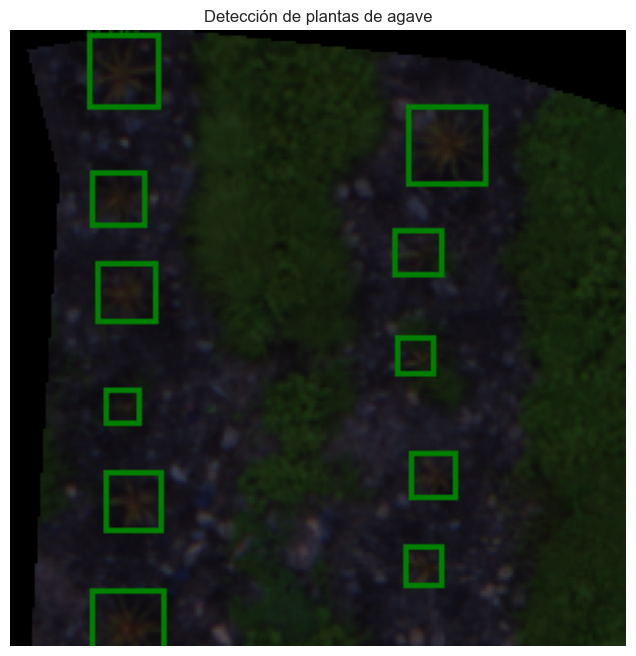

In [16]:
# Mostrar visualización de detecciones y ground truth

visualizar_agave_detectado(image[..., 0:3], boxes_pred, scores, gt_boxes)

In [ ]:
# --------------------------------------------------------------
# Análisis global: Número de detecciones por imagen en el dataset
# --------------------------------------------------------------
# Para cada imagen del conjunto, se ejecuta inferencia con el modelo
# y se contabiliza cuántas detecciones (bounding boxes) fueron generadas.
# Luego, se construye un histograma para visualizar la distribución
# del número de detecciones por imagen.
# --------------------------------------------------------------
all_images = []
all_boxes = []
all_scores = [] # Lista para almacenar los scores obtenidos por el modelo por imagen
all_agave_len = [] # Lista para almacenar el número de detecciones por imagen
all_predictions = []  # Lista para almacenar la diferencia entre la cantidad de objetos real menos la predicha
for j, ruta_imagen in enumerate(imagenes):
    ruta = pathlib.Path(ruta_imagen)
    archivo_etiqueta = etiquetas[j]
    if archivo_etiqueta:

        with open(archivo_etiqueta) as f:
            cantidad_de_etiquetas = len(f.readlines())
    else:
        cantidad_de_etiquetas = 0
    image = imread(ruta)
    image = (torch.Tensor(image[..., 0:3]).permute(2, 0, 1).unsqueeze(0)).to(device)
    diou_thr = 0.5
    conf_thr = 0.4
    boxes, scores, classes,_ = inference(model,image, 'cbbox', conf_thr, diou_thr)
    all_images.append(image[0])
    all_boxes.append(boxes[0])
    all_scores.append(scores[0])
    cantidad_agaves = len(scores[0])
    all_agave_len.append(cantidad_agaves)
    all_predictions.append(cantidad_agaves - cantidad_de_etiquetas)


In [22]:
# Lista de una sola dimensión con todos los scores obtenidos de todas las imágenes
all_scores_ = []
for nested_score in all_scores:
    all_scores_.extend([i.item() for i in nested_score])

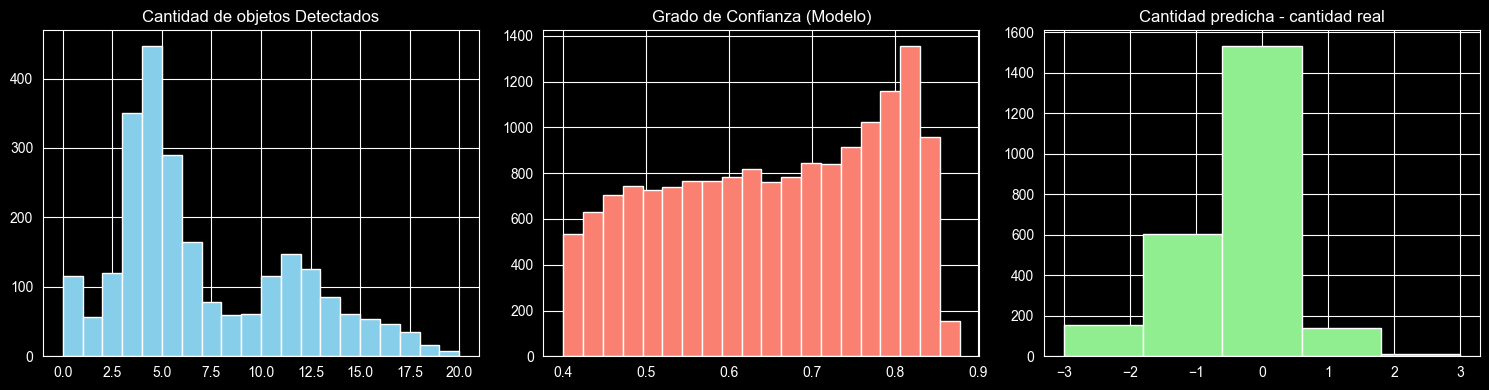

In [25]:
# --------------------------------------------------------------
# Visualización del histograma de frecuencias de detecciones, scores y la diferencia
# de la cantidad real de agaves menos la predicha por el modelo
# --------------------------------------------------------------
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.hist(all_agave_len, bins=20, color='skyblue')
plt.title("Cantidad de objetos Detectados")
plt.subplot(1, 3, 2)
plt.hist(all_scores_, bins=20, color='salmon')
plt.title("Grado de Confianza (Modelo)")
plt.subplot(1, 3, 3)
plt.hist(all_predictions, bins=5, color='lightgreen')
plt.title("Cantidad predicha - cantidad real")
plt.tight_layout()
plt.show()


## Conclusiones

Fue posible ejecutar y evaluar el modelo principal basado en Vision Transformers (bit-STED) para la detección de agaves donde se consideraron diferentes métricas del desempeño del modelo incluyendo la cantidad de objetos detectados, los scores obtenidos y finalmente el error o cantidad de agaves predicha menos la real, lo que en conjunto permitirá evaluar y comparar un posible modelo desplegado en una plataforma embebida donde, por limitaciones de hardware, puede que se requiera usar un modelo reducido o mas pequeño para la predicción. Por lo tanto estas métricas serviran como una base comparativa entre el modelo actual y aquel que se despliegue en la plataforma embebida.
